params: {'kappa': 1.2, 'q': 1.0, 'sigma': 1.5, 'L': 10.0, 'N': 200, 'mix': 0.1, 'tol': 1e-10}
converged: True iters: 152
E0 = 1.3673981149005712


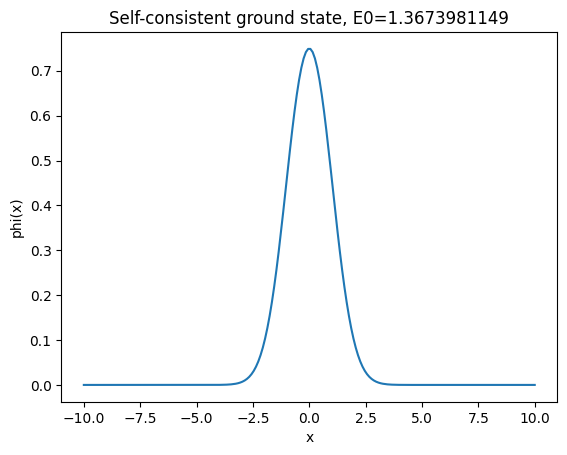

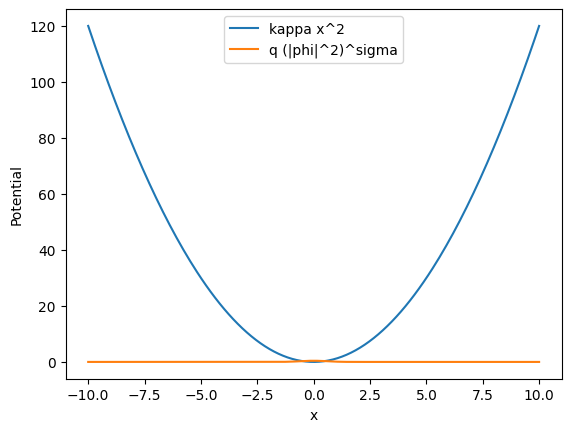

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh
from tqdm.auto import tqdm
def l2_normalize(phi, dx):
    nrm = np.sqrt(np.sum(np.abs(phi)**2) * dx)
    return phi / nrm

def build_kinetic_matrix(n, dx):
    main = (2.0 / dx**2) * np.ones(n)
    off  = (-1.0 / dx**2) * np.ones(n-1)
    return diags([off, main, off], offsets=[-1, 0, 1], format="csc")

def solve_ground_state_self_consistent(
    kappa=1.0, q=1.0, sigma=1.5,
    L=10.0, N=200,
    mix=0.10, tol=1e-10, max_iter=500,
    seed=0
):
    x_full = np.linspace(-L, L, N)
    dx = x_full[1] - x_full[0]

    x = x_full[1:-1]
    n = x.size

    T = build_kinetic_matrix(n, dx)
    Vtrap = kappa * x**2

    omega = np.sqrt(kappa)
    phi = np.exp(-0.5 * omega * x**2)
    phi = l2_normalize(phi, dx)

    rng = np.random.default_rng(seed)
    phi = l2_normalize(phi * (1.0 + 1e-3 * rng.standard_normal(n)), dx)

    E = None

    for it in range(1, max_iter + 1):
        rho = np.abs(phi)**2
        Vnl = q * (rho ** sigma)

        H = T + diags(Vtrap + Vnl, 0, format="csc")

        vals, vecs = eigsh(H, k=1, which="SA", tol=1e-12, maxiter=200000)
        E_new = float(vals[0])
        phi_new = np.array(vecs[:, 0])

        phi_new = l2_normalize(phi_new, dx)
        if np.sum(phi_new) < 0:
            phi_new = -phi_new

        phi_mixed = (1.0 - mix) * phi + mix * phi_new
        phi_mixed = l2_normalize(phi_mixed, dx)

        diff = np.sqrt(np.sum(np.abs(phi_mixed - phi)**2) * dx)

        phi = phi_mixed
        E = E_new

        if diff < tol:
            break

    phi_full = np.zeros_like(x_full)
    phi_full[1:-1] = phi

    rho_full = np.abs(phi_full)**2
    Vnl_full = q * (rho_full ** sigma)

    return {
        "x": x_full,
        "phi": phi_full,
        "rho": rho_full,
        "Vtrap": kappa * x_full**2,
        "Vnl": Vnl_full,
        "E": E,
        "dx": dx,
        "iters": it,
        "converged": (it < max_iter),
        "params": {"kappa": kappa, "q": q, "sigma": sigma, "L": L, "N": N, "mix": mix, "tol": tol}
    }

res = solve_ground_state_self_consistent(
    kappa=1.2, q=1.0, sigma=1.5,
    L=10.0, N=200,
    mix=0.10, tol=1e-10, max_iter=500
)

print("params:", res["params"])
print("converged:", res["converged"], "iters:", res["iters"])
print("E0 =", res["E"])

x = res["x"]
phi = res["phi"]
rho = res["rho"]

plt.figure()
plt.plot(x, phi)
plt.xlabel("x")
plt.ylabel("phi(x)")
plt.title(f"Self-consistent ground state, E0={res['E']:.10f}")
plt.show()

plt.figure()
plt.plot(x, res["Vtrap"], label="kappa x^2")
plt.plot(x, res["Vnl"], label="q (|phi|^2)^sigma")
plt.xlabel("x")
plt.ylabel("Potential")
plt.legend()
plt.show()


params: {'kappa': 1.2, 'q': -10.0, 'sigma': 1.5, 'L': 10.0, 'N': 200, 'mix': 0.1, 'tol': 1e-10}
converged: False iters: 500
E0 = -11.30588615557504


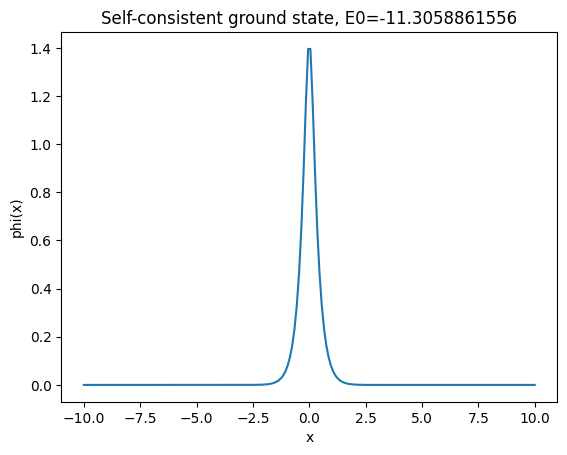

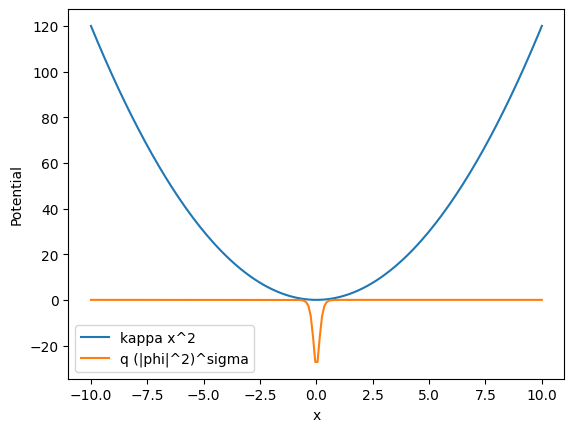

In [5]:

res = solve_ground_state_self_consistent(
    kappa=1.2, q=-10.0, sigma=1.5,
    L=10.0, N=200,
    mix=0.10, tol=1e-10, max_iter=500
)

print("params:", res["params"])
print("converged:", res["converged"], "iters:", res["iters"])
print("E0 =", res["E"])

x = res["x"]
phi = res["phi"]
rho = res["rho"]

plt.figure()
plt.plot(x, phi)
plt.xlabel("x")
plt.ylabel("phi(x)")
plt.title(f"Self-consistent ground state, E0={res['E']:.10f}")
plt.show()

plt.figure()
plt.plot(x, res["Vtrap"], label="kappa x^2")
plt.plot(x, res["Vnl"], label="q (|phi|^2)^sigma")
plt.xlabel("x")
plt.ylabel("Potential")
plt.legend()
plt.show()


In [8]:


kappa_min, kappa_max = 0.5, 3.0
q_min, q_max         = -2.0, 2.0
sigma_min, sigma_max = 0.5, 3.0

kappa_grid = np.linspace(kappa_min, kappa_max, 5)
q_grid     = np.linspace(q_min, q_max, 5)
sigma_grid = np.linspace(sigma_min, sigma_max, 5)

L = 10.0
N = 150
mix = 0.10
tol = 1e-7
max_iter = 250

rows = []

param_grid = [
    (float(k), float(q), float(s))
    for k in kappa_grid
    for q in q_grid
    for s in sigma_grid
]

for kappa, q, sigma in tqdm(param_grid, desc="Self-consistent solves"):
    res = solve_ground_state_self_consistent(
        kappa=kappa, q=q, sigma=sigma,
        L=L, N=N, mix=mix, tol=tol, max_iter=max_iter, seed=0
    )
    rows.append({
        "kappa": kappa,
        "q": q,
        "sigma": sigma,
        "E": float(res["E"]) if res["E"] is not None else np.nan,
        "iters": int(res["iters"]),
        "converged": bool(res["converged"])
    })

df = pd.DataFrame(rows)

csv_path = "gpe_self_consistent_energies_5x5x5.csv"
df.to_csv(csv_path, index=False)

print("Saved:", csv_path)
display(df.head())


Self-consistent solves:   0%|          | 0/125 [00:00<?, ?it/s]

Saved: gpe_self_consistent_energies_5x5x5.csv


,kappa,q,sigma,E,iters,converged
0,0.5,-2.0,0.500,-0.475024,135,True
1,0.5,-2.0,1.125,0.034983,139,True
2,0.5,-2.0,1.750,0.326116,133,True
3,0.5,-2.0,2.375,0.493468,122,True
4,0.5,-2.0,3.000,0.586840,111,True


Dense curve: E vs kappa:   0%|          | 0/41 [00:00<?, ?it/s]

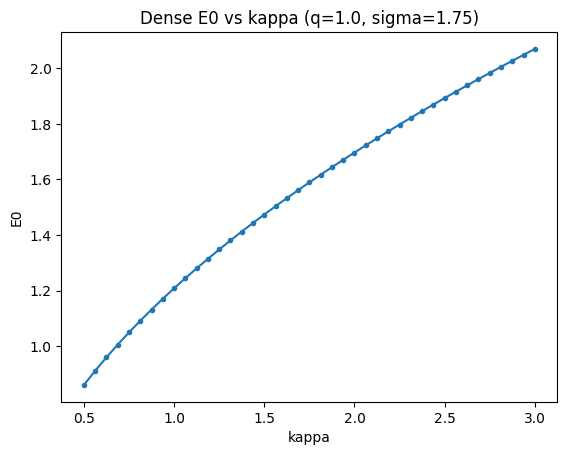

Dense curve: E vs q:   0%|          | 0/41 [00:00<?, ?it/s]

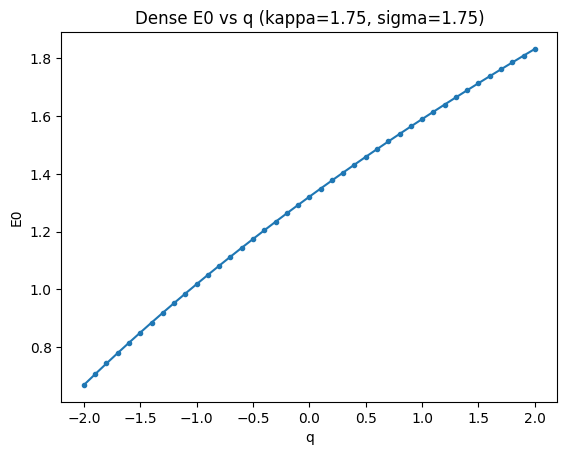

Dense curve: E vs sigma:   0%|          | 0/41 [00:00<?, ?it/s]

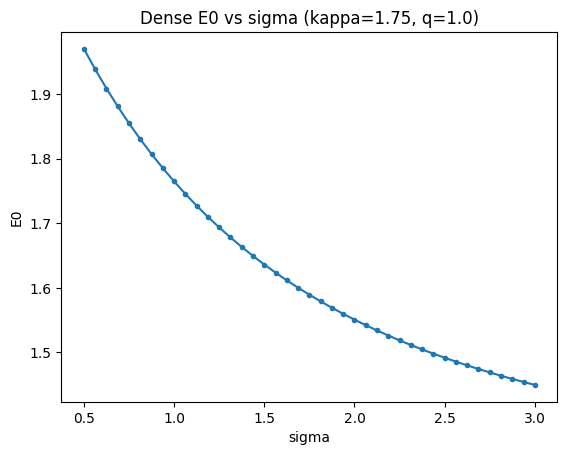

Rainbow phi varying sigma:   0%|          | 0/15 [00:00<?, ?it/s]

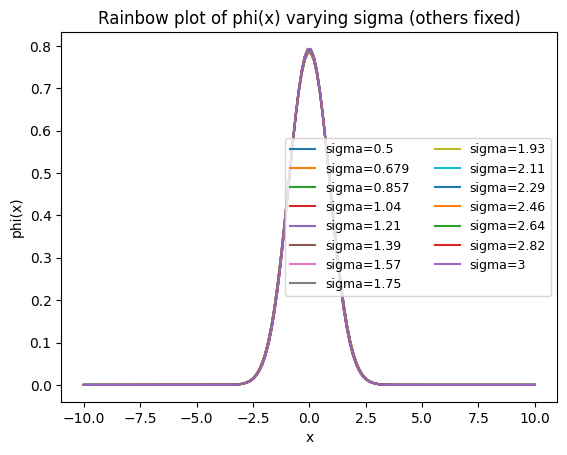

In [9]:
# Dense 1D energy slices (other two params fixed), plus optional "rainbow" phi plot
# Assumes df exists (from the grid run) and solve_ground_state_self_consistent is defined.

def closest_val(arr, v):
    arr = np.asarray(arr, dtype=float)
    return float(arr[np.argmin(np.abs(arr - v))])

kappa0 = closest_val(kappa_grid, np.median(kappa_grid))
q0     = closest_val(q_grid,     np.median(q_grid))
sigma0 = closest_val(sigma_grid, np.median(sigma_grid))

# pick fixed values (override if you want)
kappa_fix = kappa0
sigma_fix = sigma0
q_fix     = q0

# If we vary sigma, make sure q != 0 (otherwise sigma has no effect)
if np.isclose(q_fix, 0.0):
    q_fix = float(q_grid[len(q_grid)//2 + 1]) if len(q_grid) > 1 else 1.0

L = 10.0
N = 150
mix = 0.10
tol = 1e-7
max_iter = 250

def dense_energy_curve(vary="kappa", num=35):
    if vary == "kappa":
        vals = np.linspace(kappa_min, kappa_max, num)
        fixed = dict(q=q_fix, sigma=sigma_fix)
    elif vary == "q":
        vals = np.linspace(q_min, q_max, num)
        fixed = dict(kappa=kappa_fix, sigma=sigma_fix)
    elif vary == "sigma":
        vals = np.linspace(sigma_min, sigma_max, num)
        fixed = dict(kappa=kappa_fix, q=q_fix)
    else:
        raise ValueError("vary must be 'kappa', 'q', or 'sigma'")

    Es = np.empty_like(vals, dtype=float)
    iters = np.empty_like(vals, dtype=int)
    conv = np.empty_like(vals, dtype=bool)

    phi_seed = None
    for i, v in enumerate(tqdm(vals, desc=f"Dense curve: E vs {vary}")):
        params = dict(kappa=kappa_fix, q=q_fix, sigma=sigma_fix)
        params.update(fixed)
        params[vary] = float(v)

        res = solve_ground_state_self_consistent(
            **params, L=L, N=N, mix=mix, tol=tol, max_iter=max_iter, seed=0
        )

        Es[i] = float(res["E"]) if res["E"] is not None else np.nan
        iters[i] = int(res["iters"])
        conv[i] = bool(res["converged"])

    return vals, Es, iters, conv

# --- Three dense plots ---
vals, Es, iters, conv = dense_energy_curve("kappa", num=41)
plt.figure()
plt.plot(vals, Es, marker=".", linestyle="-")
plt.xlabel("kappa")
plt.ylabel("E0")
plt.title(f"Dense E0 vs kappa (q={q_fix}, sigma={sigma_fix})")
plt.show()

vals, Es, iters, conv = dense_energy_curve("q", num=41)
plt.figure()
plt.plot(vals, Es, marker=".", linestyle="-")
plt.xlabel("q")
plt.ylabel("E0")
plt.title(f"Dense E0 vs q (kappa={kappa_fix}, sigma={sigma_fix})")
plt.show()

vals, Es, iters, conv = dense_energy_curve("sigma", num=41)
plt.figure()
plt.plot(vals, Es, marker=".", linestyle="-")
plt.xlabel("sigma")
plt.ylabel("E0")
plt.title(f"Dense E0 vs sigma (kappa={kappa_fix}, q={q_fix})")
plt.show()

# --- Optional: dense "rainbow" wavefunctions varying one parameter ---
vary_phi = "sigma"  # "kappa" or "q" or "sigma"
num_phi = 15        # keep modest so the plot stays readable
vals = (np.linspace(kappa_min, kappa_max, num_phi) if vary_phi == "kappa" else
        np.linspace(q_min, q_max, num_phi) if vary_phi == "q" else
        np.linspace(sigma_min, sigma_max, num_phi))

if vary_phi == "sigma" and np.isclose(q_fix, 0.0):
    q_fix = 1.0

phis = []
x_axis = None

for v in tqdm(vals, desc=f"Rainbow phi varying {vary_phi}"):
    params = dict(kappa=kappa_fix, q=q_fix, sigma=sigma_fix)
    if vary_phi == "kappa":
        params["kappa"] = float(v)
    elif vary_phi == "q":
        params["q"] = float(v)
    else:
        params["sigma"] = float(v)

    res = solve_ground_state_self_consistent(
        **params, L=L, N=N, mix=mix, tol=tol, max_iter=max_iter, seed=0
    )
    x_axis = res["x"]
    phis.append(res["phi"])

plt.figure()
for i, v in enumerate(vals):
    plt.plot(x_axis, phis[i], label=f"{vary_phi}={float(v):.3g}")
plt.xlabel("x")
plt.ylabel("phi(x)")
plt.title(f"Rainbow plot of phi(x) varying {vary_phi} (others fixed)")
plt.legend(ncols=2, fontsize=9)
plt.show()
